# Heart Failure Clinical Records – Random Forest 分析實作（Colab Notebook）

本 Notebook 示範如何對 **heart_failure_clinical_records_dataset.csv** 進行：
- 資料讀取與基本探索（EDA）
- Random Forest 建模與評估（Accuracy、Classification Report、Confusion Matrix、ROC AUC）
- 所有測試樣本的投票狀況（每棵樹對每個樣本的投票）
- 單一決策樹的分裂規則與樹狀圖
- Bootstrap 抽樣（Bagging）示意


In [33]:
# =========================================
# 0. 載入套件
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.tree import export_text, plot_tree

# 在 Jupyter / Colab 中顯示圖形
%matplotlib inline

# 圖片風格（可依喜好調整）
sns.set(style="whitegrid", font_scale=1.1)


## 1. 讀取資料
請先將 `heart_failure_clinical_records_dataset.csv` 上傳到 Colab 工作目錄。

如果你是用 Google Colab，可以使用左側檔案面板上傳，或使用 `files.upload()`。

In [34]:
# =========================================
# 1. 讀取資料
# =========================================
# 如果檔案已經在目前目錄底下：
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/heart_failure_clinical_records_dataset.csv")

# 如果你想用手動上傳的方式，請改用下面這段（解除註解）：
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv(list(uploaded.keys())[0])

df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## 2. 資料概覽與基本探索（EDA）

===== df.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000



===== 缺失值檢查 =====
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20129 (\N{CJK UNIFIED IDEOGRAPH-4EA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


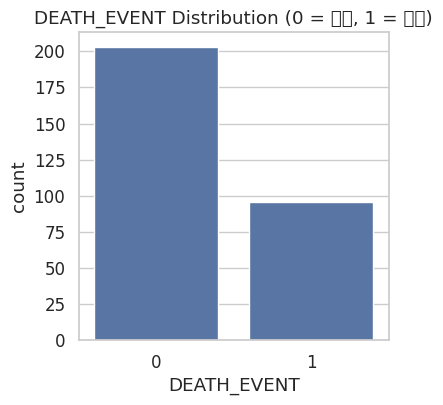

In [35]:
# =========================================
# 2. 資料概覽與基本探索（EDA）
# =========================================
print("===== df.info() =====")
print(df.info())

print("\n===== df.describe() =====")
display(df.describe())

# 檢查缺失值
print("\n===== 缺失值檢查 =====")
print(df.isnull().sum())

# 目標變數 DEATH_EVENT 的分布
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x="DEATH_EVENT")
plt.title("DEATH_EVENT Distribution (0 = 存活, 1 = 死亡)")
plt.show()


In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

## 3. 訓練集 / 測試集切分

In [37]:
# =========================================
# 3. 切分訓練集 / 測試集
# =========================================
X = df.drop("DEATH_EVENT", axis=1)
y = df["DEATH_EVENT"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("訓練集大小:", X_train.shape)
print("測試集大小:", X_test.shape)


訓練集大小: (239, 12)
測試集大小: (60, 12)


## 4. 建立與訓練 Random Forest 模型

In [38]:
# =========================================
# 4. 建立 Random Forest 模型並訓練
# =========================================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # 處理類別不平衡
)

rf.fit(X_train, y_train)
print("Random Forest 模型已完成訓練。共有", len(rf.estimators_), "棵樹。")


Random Forest 模型已完成訓練。共有 300 棵樹。


## 5. 所有測試樣本的投票狀況
此段顯示：
- 每一個測試樣本，所有樹中有多少票投 0 / 1
- RandomForest 的最終預測


In [58]:
# =========================================
# 5A. 所有測試樣本的投票狀況
# =========================================
# votes 形狀: (n_trees, n_samples_test)
votes = np.array([est.predict(X_test.values) for est in rf.estimators_])

# 計算每個樣本被投 0 / 1 的次數
vote_0_counts = np.sum(votes == 0, axis=0)
vote_1_counts = np.sum(votes == 1, axis=0)

# print(len(vote_0_counts), len(vote_1_counts))

# RandomForest 最終預測
rf_pred = rf.predict(X_test)

vote_df = pd.DataFrame({
    "true_label": y_test.values,
    "rf_pred": rf_pred,
    "vote_0": vote_0_counts,
    "vote_1": vote_1_counts
}).reset_index(drop=True)

# 只顯示前 10 筆
vote_df.head(10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,true_label,rf_pred,vote_0,vote_1
0,0,0,250,50
1,0,0,274,26
2,0,0,218,82
3,0,0,200,100
4,0,0,264,36
5,0,0,266,34
6,0,0,294,6
7,1,0,230,70
8,0,0,292,8
9,0,1,127,173


## 6. 單一決策樹的分裂規則與樹狀圖
示範：隨機森林中的第 1 棵樹。

In [59]:
# =========================================
# 6A. 顯示第 1 棵樹的文字規則
# =========================================
tree0 = rf.estimators_[0]

# 部分 sklearn 版本會自動帶有 feature_names_in_，如果沒有就補上
if not hasattr(tree0, "feature_names_in_"):
    tree0.feature_names_in_ = np.array(X.columns)

tree_rules = export_text(tree0, feature_names=list(X.columns))
print(tree_rules)


|--- serum_sodium <= 136.50
|   |--- ejection_fraction <= 22.50
|   |   |--- class: 1.0
|   |--- ejection_fraction >  22.50
|   |   |--- creatinine_phosphokinase <= 51.50
|   |   |   |--- class: 1.0
|   |   |--- creatinine_phosphokinase >  51.50
|   |   |   |--- platelets <= 378000.00
|   |   |   |   |--- time <= 82.50
|   |   |   |   |   |--- creatinine_phosphokinase <= 68.00
|   |   |   |   |   |   |--- platelets <= 237500.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- platelets >  237500.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- creatinine_phosphokinase >  68.00
|   |   |   |   |   |   |--- serum_sodium <= 131.50
|   |   |   |   |   |   |   |--- smoking <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- smoking >  0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- serum_sodium >  131.50
|   |   |   |   |   |   |   |--- age <= 52.50
|   |   |   |   |   |   |

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23652 (\N{CJK UNIFIED IDEOGRAPH-5C64}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  fig.canvas

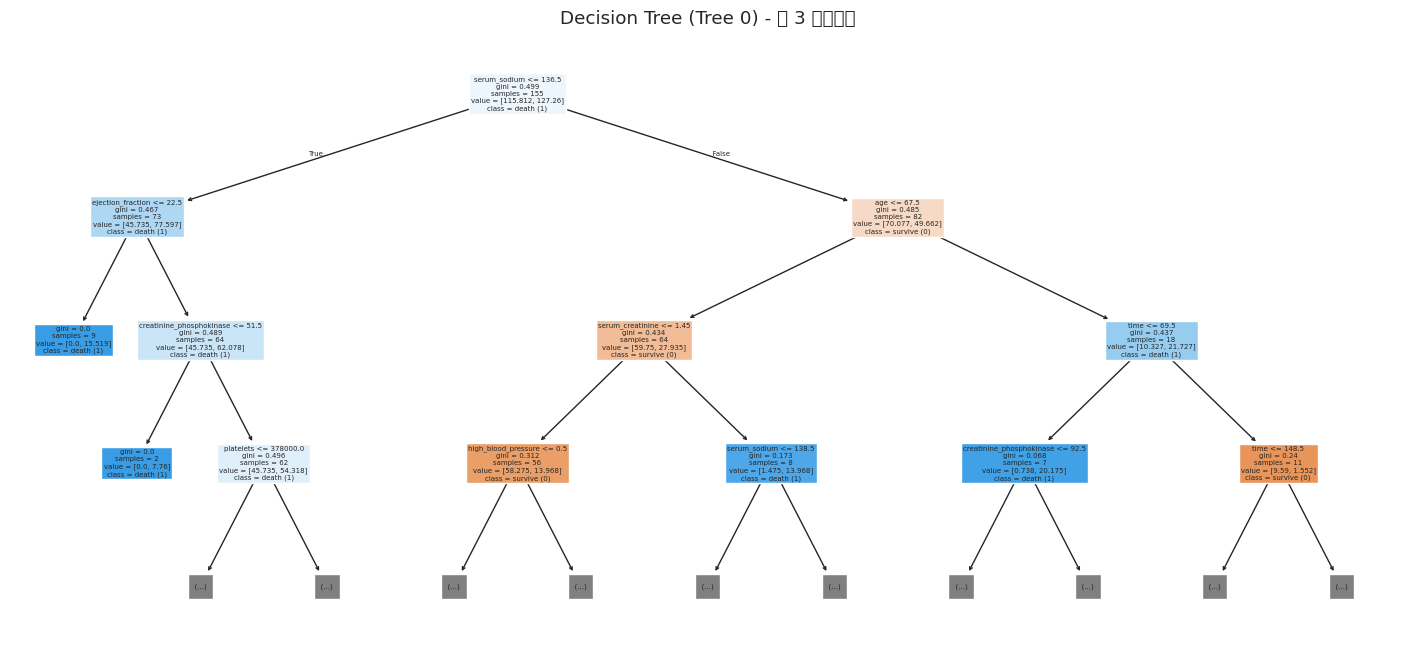

In [41]:
# =========================================
# 6B. 畫出第 1 棵樹的前幾層結構
# =========================================
plt.figure(figsize=(18, 8))
plot_tree(
    tree0,
    feature_names=list(X.columns),
    class_names=["survive (0)", "death (1)"],
    filled=True,
    max_depth=3  # 只畫前 3 層，避免太複雜
)
plt.title("Decision Tree (Tree 0) - 前 3 層示意圖")
plt.show()


## 7. Bootstrap 抽樣（Bagging）過程示意
示範前 3 棵樹的 bootstrap 抽樣情形。

In [42]:
# =========================================
# 7. Bootstrap 抽樣示意（前 3 棵樹）
# =========================================
train_indices = X_train.index.to_numpy()
n_samples_train = len(train_indices)

n_show_trees = 3

for i, estimator in enumerate(rf.estimators_[:n_show_trees]):
    rs = np.random.RandomState(estimator.random_state)

    # 有放回抽樣 n_samples_train 次
    sampled_pos = rs.randint(0, n_samples_train, n_samples_train)
    sampled_indices = train_indices[sampled_pos]

    print(f"\n====== 第 {i+1} 棵樹的 bootstrap 抽樣結果 ======")
    print("總共抽樣次數:", len(sampled_indices))
    print("不同樣本數:", len(np.unique(sampled_indices)))

    print("前 10 個被抽到的訓練樣本 index:", sampled_indices[:10])

    counts = pd.Series(sampled_indices).value_counts().head(5)
    print("\n被抽最多的前 5 個樣本及其被抽次數:")
    print(counts)



====== 第 1 棵樹的 bootstrap 抽樣結果 ======
總共抽樣次數: 239
不同樣本數: 155
前 10 個被抽到的訓練樣本 index: [217  46  31  96   8 138 128 248 199  37]

被抽最多的前 5 個樣本及其被抽次數:
57     5
1      4
156    4
208    3
3      3
Name: count, dtype: int64

====== 第 2 棵樹的 bootstrap 抽樣結果 ======
總共抽樣次數: 239
不同樣本數: 151
前 10 個被抽到的訓練樣本 index: [281 279   1 283 296 229 247 173 133  96]

被抽最多的前 5 個樣本及其被抽次數:
12     4
162    4
208    4
45     4
128    4
Name: count, dtype: int64

====== 第 3 棵樹的 bootstrap 抽樣結果 ======
總共抽樣次數: 239
不同樣本數: 146
前 10 個被抽到的訓練樣本 index: [165 281 137 126 248  95 259 216  29 191]

被抽最多的前 5 個樣本及其被抽次數:
192    5
270    5
236    4
277    4
151    4
Name: count, dtype: int64


## 8. 模型評估：Accuracy、Classification Report、混淆矩陣、ROC AUC、特徵重要度

In [43]:
# =========================================
# 8A. 預測與基本評估指標
# =========================================
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60



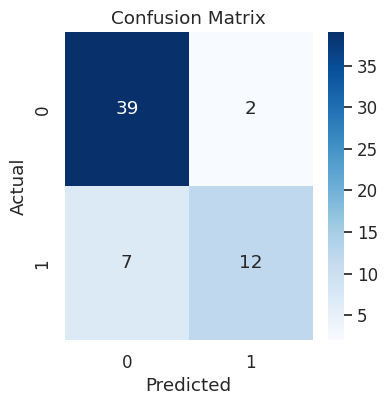

In [44]:
# =========================================
# 8B. 混淆矩陣
# =========================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


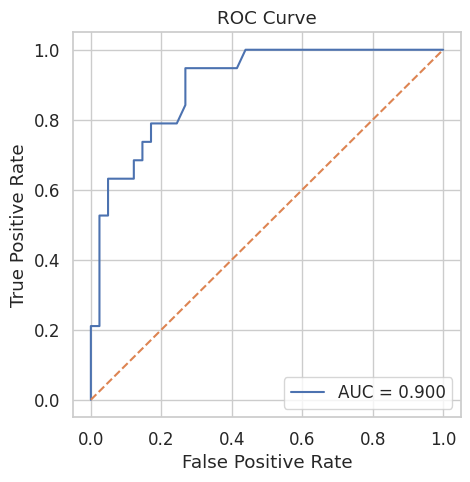

In [45]:
# =========================================
# 8C. ROC 曲線與 AUC
# =========================================
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


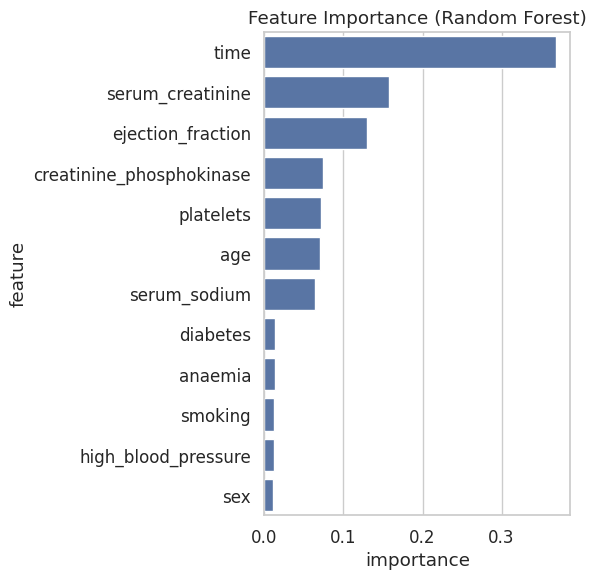

,feature,importance
11,time,0.368621
7,serum_creatinine,0.157395
4,ejection_fraction,0.129925
2,creatinine_phosphokinase,0.074724
6,platelets,0.072157
0,age,0.070548
8,serum_sodium,0.064070
3,diabetes,0.013501
1,anaemia,0.013006
10,smoking,0.012403


In [46]:
# =========================================
# 8D. 特徵重要度
# =========================================
importances = rf.feature_importances_
feature_names = X.columns

fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

fi


## 9. （選用）交叉驗證與超參數調整
如果需要，可以在這裡加上 GridSearchCV 或 cross_val_score 的設定。
（此 Notebook 先聚焦在 Random Forest 機制與解釋上。）